<a href="https://colab.research.google.com/github/stephenjkaplan/snow-grooming-object-detection/blob/master/Snow_Grooming_Object_Detection_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

##### Download additional utility files.

Torchvision

In [1]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


Get YouTube Downloader

In [2]:
!git clone https://github.com/ankandrew/YT-Downloader-Trimmer.git ytdownloader    # for downloading and trimming videos
!pip install -r /content/ytdownloader/requirements.txt            

fatal: destination path 'ytdownloader' already exists and is not an empty directory.


##### Useful global variables.

In [3]:
obj_class_labels = ['tree', 'person', 'street light']

In [4]:
root_dir = '/content/drive/My Drive/Colab Notebooks/snow_grooming/'

##### Imports 

In [5]:
import os
import sys
import time
from datetime import datetime
from google.colab import drive
drive.mount("/content/drive")

import numpy as np
from PIL import Image
from ytdownloader.downloader import Downloader

import cv2
import utils
import torch
import torchvision

# custom modules
import sys
root_dir = '/content/drive/My Drive/Colab Notebooks/snow_grooming/'
sys.path.append(root_dir)

from utilities import train_model
from dataset import GoogleOpenImageDataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Explore data format.

In [7]:
dataset = GoogleOpenImageDataset(root_dir, obj_class_labels, max_images_per_class=2000, train=True)

In [8]:
dataset[40]

(tensor([[[0.1608, 0.1529, 0.1490,  ..., 0.0039, 0.0078, 0.0078],
          [0.1647, 0.1569, 0.1451,  ..., 0.0118, 0.0118, 0.0157],
          [0.1686, 0.1608, 0.1529,  ..., 0.0078, 0.0078, 0.0078],
          ...,
          [0.6392, 0.6431, 0.6431,  ..., 0.5765, 0.5686, 0.5882],
          [0.6314, 0.6353, 0.6392,  ..., 0.5882, 0.5725, 0.5686],
          [0.6157, 0.6196, 0.6235,  ..., 0.5961, 0.5804, 0.5765]],
 
         [[0.4039, 0.4039, 0.4039,  ..., 0.3255, 0.3294, 0.3294],
          [0.4078, 0.4078, 0.4000,  ..., 0.3333, 0.3333, 0.3373],
          [0.4118, 0.4118, 0.4078,  ..., 0.3294, 0.3294, 0.3294],
          ...,
          [0.6510, 0.6549, 0.6549,  ..., 0.6000, 0.5922, 0.6118],
          [0.6431, 0.6471, 0.6510,  ..., 0.6118, 0.5961, 0.5922],
          [0.6275, 0.6314, 0.6353,  ..., 0.6196, 0.6039, 0.6000]],
 
         [[0.5490, 0.5451, 0.5529,  ..., 0.4824, 0.4784, 0.4784],
          [0.5529, 0.5490, 0.5490,  ..., 0.4902, 0.4824, 0.4863],
          [0.5569, 0.5529, 0.5569,  ...,

### Model Selection

*Note: I would have preferred to do K-Folds Cross Validation while selecting the model, but iteration was too slow given the time constraints of the project. I chose to just use one training and validation set, but recognize that isn't an optimal strategy for hyperparameter selection.*

##### Create training / validation / test dataset splits.

In [9]:
# create 2 versions of the dataset. one used for training 
dataset_train = GoogleOpenImageDataset(root_dir, obj_class_labels, max_images_per_class=5000, train=True)
dataset_train_val = GoogleOpenImageDataset(root_dir, obj_class_labels, max_images_per_class=5000, train=True)
dataset_val = GoogleOpenImageDataset(root_dir, obj_class_labels, max_images_per_class=5000)
dataset_test = GoogleOpenImageDataset(root_dir, obj_class_labels, max_images_per_class=5000)

In [10]:
total_size = len(dataset_test)

# for trainval/test split
train_val_percent = 0.80
test_percent = 0.20
train_val_size = int(train_val_percent*total_size)
test_size = total_size - train_val_size
splits_1 = [train_val_size, test_size]

# for train/val split
train_percent = 0.80
val_percent = 0.20
train_size = int(train_percent*train_val_size)
val_size = train_val_size - train_size
splits_2 = [train_size, val_size]

In [11]:
# split the dataset in train, val and test set
torch.manual_seed(1)
indices = torch.randperm(total_size).tolist()

train_val_idx, test_idx = torch.utils.data.random_split(indices, splits_1)
train_idx, val_idx = torch.utils.data.random_split(train_val_idx, splits_2)

# make subsets based on train/val/test splits
dataset_train_val = torch.utils.data.Subset(dataset_train_val, train_val_idx)
dataset_train = torch.utils.data.Subset(dataset_train, train_idx)
dataset_val = torch.utils.data.Subset(dataset_val, val_idx)
dataset_test = torch.utils.data.Subset(dataset_test, test_idx)

# define training and validation data loaders
data_loader_train_val = torch.utils.data.DataLoader(
    dataset_train_val, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

##### Define hyperparameters.


In [12]:
# optimizer
learning_rate = 0.001
momentum = 0.9
weight_decay = 0.0005

# learning rate schedule
step_size = 3   # learning rate will step every __ epochs
gamma = 0.1    # learning rate will be multiplied by gamma every step 

num_epochs = 10
trainable_layers = 3

##### Train Neural Network

In [13]:
assert False

AssertionError: ignored

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [   0/4439]  eta: 5:01:36  lr: 0.000002  loss: 2.4437 (2.4437)  loss_classifier: 1.6370 (1.6370)  loss_box_reg: 0.1844 (0.1844)  loss_objectness: 0.5860 (0.5860)  loss_rpn_box_reg: 0.0364 (0.0364)  time: 4.0767  data: 2.9784  max mem: 2962
Epoch: [0]  [ 100/4439]  eta: 0:53:17  lr: 0.000102  loss: 0.3776 (0.9915)  loss_classifier: 0.1240 (0.5930)  loss_box_reg: 0.0738 (0.0805)  loss_objectness: 0.1359 (0.2823)  loss_rpn_box_reg: 0.0179 (0.0356)  time: 0.6810  data: 0.4758  max mem: 4038
Epoch: [0]  [ 200/4439]  eta: 0:50:54  lr: 0.000202  loss: 0.2922 (0.7272)  loss_classifier: 0.1437 (0.3764)  loss_box_reg: 0.0918 (0.0978)  loss_objectness: 0.0688 (0.2156)  loss_rpn_box_reg: 0.0142 (0.0373)  time: 0.6881  data: 0.4714  max mem: 4038
Epoch: [0]  [ 300/4439]  eta: 0:49:01  lr: 0.000302  loss: 0.2510 (0.6171)  loss_classifier: 0.1048 (0.2915)  loss_box_reg: 0.0553 (0.0913)  loss_objectness: 0.0948 (0.1966)  loss_rpn_box_reg: 0.0096 (0.0377)  time: 0.7027  data: 0.4913  max me

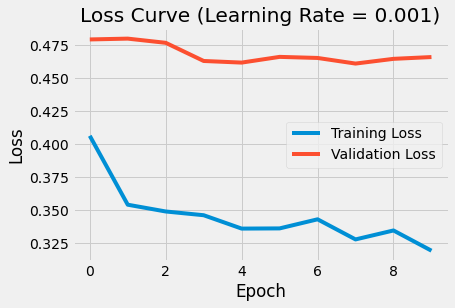

In [14]:
train_model(obj_class_labels, trainable_layers, device, learning_rate, momentum, 
            weight_decay, step_size, gamma, num_epochs, data_loader_train, 
            data_loader_val=data_loader_val, score_val=True)

### Final Model

#### Train Neural Network
Train final model with ALL training data.

In [15]:
train_model(obj_class_labels, trainable_layers, device, learning_rate, momentum, 
            weight_decay, step_size, gamma, num_epochs=5, 
            data_loader_train=data_loader_train_val, data_loader_val=data_loader_test) 

Epoch: [0]  [   0/5549]  eta: 0:51:25  lr: 0.000002  loss: 1.6699 (1.6699)  loss_classifier: 1.4951 (1.4951)  loss_box_reg: 0.1620 (0.1620)  loss_objectness: 0.0055 (0.0055)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 0.5560  data: 0.2994  max mem: 4739


KeyboardInterrupt: ignored

#### Evaluate on test set.

In [ ]:
evaluate(model, data_loader_test, device=device)

#### Persist model.

In [ ]:
torch.save(model, f'{root_dir}models/final_model.pkl')

### Prediction & Visualization

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/snow_grooming/models/final_model.pkl')

##### Pick an image from the test set.

In [ ]:
test_img_idx = 400

In [ ]:
# pick one image from the test set
img, _ = dataset_test[test_img_idx]

Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

##### Make a boundary box prediction.

In [ ]:
def make_boundary_box_prediction(image_no_box):
# put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([image_no_box.to(device)])

  return prediction

In [ ]:
predict_example = make_boundary_box_prediction(img)
predict_example

##### Define function for drawing boundary box.

In [ ]:
class_lookup_table = {
    1: (obj_class_labels[0], (255, 0, 0)),
    2: (obj_class_labels[1], (0, 255, 0)),
    3: (obj_class_labels[2], (255, 255, 0)),
}

def draw_all_boundary_boxes(image_path, prediction, threshold=0.5):
    # get boundary boxes, scores, and labels from prediction
    boxes = prediction[0]['boxes'].tolist()
    scores = prediction[0]['scores'].tolist()
    class_labels = prediction[0]['labels'].tolist()    

    image = cv2.imread(image_path)
    # im is a PIL Image object
    #im_arr = np.asarray(image)
    for box, score, label in zip(boxes, scores, class_labels):
      # convert rgb array to opencv's bgr format
      #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
      if score < threshold:
        continue
      x1 = int(box[0])
      y1 = int(box[3])
      x2 = int(box[2])
      y2 = int(box[1])
      # pts1 and pts2 are the upper left and bottom right coordinates of the rectangle
      cv2.rectangle(image, (x1, y1), (x2, y2), class_lookup_table[label][1], 3)
      obj_label = 'pole' if class_lookup_table[label][0] == 'street light' else class_lookup_table[label][0]
      cv2.putText(image, obj_label, (x1, y2-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, class_lookup_table[label][1], 2)
    #im_arr = cv2.cvtColor(im_arr_bgr, cv2.COLOR_BGR2RGB)
    #Image.fromarray(image)
    return image


In [ ]:
test_img_idx_abs = test_idx[test_img_idx]
path = dataset.imgs[test_img_idx_abs]

In [ ]:
image = draw_all_boundary_boxes(path, predict_example)
Image.fromarray(image)

### Demo

Demo on ski resort video footage.

##### Download video from YouTube.



In [ ]:
video_url = "https://www.youtube.com/watch?v=3tg_DOaUZ4Y"
#video_url = "https://www.youtube.com/watch?v=LKBQ0J-RUF8"
video_quality = 1080 
only_video = True 
do_trim = False 
start = "00:28:16" 
end = "00:28:46"
output_file = 'pb600_winchcat_full.mp4'
#output_file = 'groomer.mp4'

In [ ]:
yt_d = Downloader(video_url, output_file, quality=video_quality, only_vid=only_video)
yt_d.download()

if do_trim:
  yt_d.trim(start, end, delete_original=False)
  os.rename('downloaded_vid_trimmed.mp4', 'downloaded_vid.mp4')

In [ ]:
for f in os.listdir():
  if 'frame' in f:
    os.remove(f)

##### Split video into frames.

In [ ]:
cap = cv2.VideoCapture('pb600_winchcat_full.mp4')
#cap = cv2.VideoCapture('groomer.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('frame'+str(i)+'.jpg',frame)
    i+=1

cap.release()
cv2.destroyAllWindows()
print(f'{i + 1} Frames Created.')

##### Draw boundary boxes on each frame.

In [ ]:
for idx in range(i):
  if idx % 100 == 0:
    print(f'Making boundary box predictions ({idx}/{i})...')

  # load image
  img_frame = Image.open(f'frame{idx}.jpg').convert("RGB")
  transforms = get_transform(train=False)
  # make prediction
  prediction = make_boundary_box_prediction(transforms(img_frame))

  # draw box
  img_frame = draw_all_boundary_boxes(f'frame{idx}.jpg', prediction) 

  # resave image
  cv2.imwrite(f'frame{idx}.jpg', img_frame)

print('Done!')

In [ ]:
Image.open('frame6100.jpg').convert("RGB")

In [ ]:
def convert_frames_to_video(num_frames,path_out,fps):
    frame_array = []
    files = [f'frame{idx}.jpg' for idx in range(num_frames)]
 
    #for sorting the file names properly
    #files.sort(key = lambda x: int(x[5:-4]))
    for f, filename in enumerate(files):
        if f % 100 == 0:
            print(f'Processing frame ({f}/{len(files)})...')
        try:
          #reading each files
          img = cv2.imread(filename)
          height, width, layers = img.shape
          size = (width,height)
          #inserting the frames into an image array
          frame_array.append(img)
        except AttributeError:
          continue
 
    out = cv2.VideoWriter(path_out,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

convert_frames_to_video(i + 1, root_dir + '/groomer_boxes.mp4', fps=30)